In [201]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

In [202]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv


class LinReg:
    def __init__(self, csv_filename):
        self.filename = csv_filename
        self.xs = []
        self.ys = []
        self.intercept = 0.
        self.slope = 0.
        self.title = ''
        self.header = ['','']
        self.unit = ['','']
        with open(self.filename, 'r') as file:
            reader = csv.reader(file, delimiter='\t')
            self.title = next(reader)[0]
            self.header = next(reader)
            self.unit = next(reader)
            for row in reader:
                self.xs.append(float(row[0]))
                self.ys.append(float(row[1]))

        f = lambda x, a, b: a * x + b
        popt, pcov = curve_fit(f, self.xs, self.ys)
        self.xs_fit = np.array([self.xs[0],self.xs[-1]])
        self.ys_fit = popt[0] * self.xs_fit + popt[1]
        self.slope = popt[0]
        self.intercept = popt[1]

    # def plot_line(self, ax, range = None):

    #     ax.plot(xs_fit, ys_fit, color = 'r', linestyle='--',
    #             label=f'slope: {popt[0]:0.3e} \nintercept: {popt[1]:0.3e} ')
        

    def plot(self, origin=True):
        fig, ax = plt.subplots(1,1,figsize=(8,6))
        ax.set_title(self.title)

        ax.set_xlabel(rf'{self.header[0]} ({self.unit[0]})')
        ax.set_ylabel(rf'{self.header[1]} ({self.unit[1]})')
        ax.grid()
        ax.scatter(self.xs, self.ys, label='data')
        if origin:
            ax.set_xlim(0)
            ax.set_ylim(0)
        ax.plot(self.xs_fit, self.ys_fit, color = 'r', linestyle='-.',label=f'slope: {self.slope:0.3} \nintercept: {self.intercept:0.3} ')
        plt.legend()

# 計算 g factor
$$ g_F = \frac{hf}{\mu_B B} $$
uncertainty:
$$ u_g = g_F\sqrt{(u_B/B)^2+(u_f/f)^2} $$

In [203]:
h = 6.62607015E-34
i = ufloat(0.200,0.003)
mu = 4*np.pi*1e-7 # 真空磁導率
mu_B = 9.2740100783e-24 # 波爾磁子
N = 125
R = ufloat(0.2406,0.0003)
print('B=', b := (4/5)**(3/2)* mu * N * i / R)

i_v = ufloat(0.045, 0.003)
R_v = ufloat(0.1530, 0.0003)
print('Bv=', bv := (4/5)**(3/2) * mu * 100 * i_v / R_v)

uf = 3

B= (9.34+/-0.14)e-05
Bv= (2.64+/-0.18)e-05


In [204]:
def get_g_from_f(f1,f2):
    f1 = ufloat(f1,uf)
    f2 = ufloat(f2,uf)
    print('f=',f := (f1+f2)/2*1e3)
    print('g=',g := h*f/mu_B/b)

In [205]:
print("高高")
f1, f2 = 1152, 360
get_g_from_f(f1,f2)
print("高低")
f1, f2 = 951, 478
get_g_from_f(f1,f2)

高高
f= (7.560+/-0.021)e+05
g= 0.578+/-0.009
高低
f= (7.145+/-0.021)e+05
g= 0.546+/-0.008


# 地磁

In [206]:
def get_bh(f1,f2, g):
    f1 = ufloat(f1,uf)
    f2 = ufloat(f2,uf)
    f = (f1-f2)/2 * 1000
    print("B_h=", bh := h * f / mu_B / g)
    return bh

bh85 = get_bh(765, 405, 1/3)
bh87 = get_bh(1152, 604, 1/2)
bh = (bh85+bh87)/2
bv, bh
print('B_earth=', B_earth := (bh*bh+bv*bv)**0.5)

B_h= (3.86+/-0.05)e-05
B_h= (3.915+/-0.030)e-05
B_earth= (4.70+/-0.10)e-05


# Breit-Rabi

# 截面積

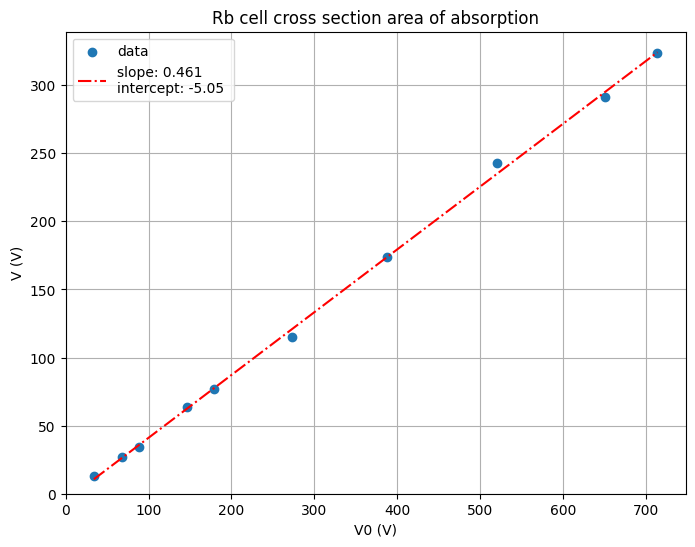

In [207]:
rho = 1.60575E+17

linreg = LinReg('Rb_cell_cross_section_area_of_absorption.csv')
linreg.plot()

In [208]:
raw_data = LinReg('Detector_Output_Voltage_and_Temperature.csv')
rho_T = LinReg('Rb_rho_and_temperature.csv')

/var/folders/74/cszmvy4n761d8d2zvdgh5gbw0000gn/T/ipykernel_36449/653148596.py:27: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f, self.xs, self.ys)


In [209]:
from scipy.interpolate import interp1d
rho_of_T = interp1d(rho_T.xs, rho_T.ys)
rho_of_T(340)

array(4.3e+17)

In [210]:
V = raw_data.ys
rho = rho_of_T(raw_data.xs)*1E-18

Text(0.5, 0, 'Density $\\rho\\ (10^{18} m^{-3})$')

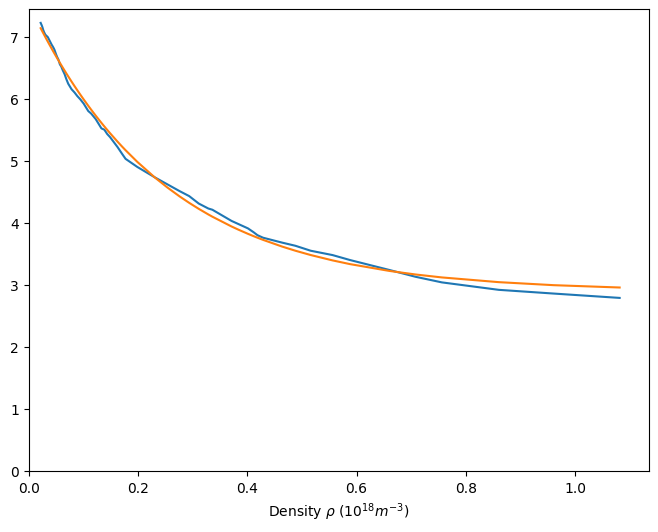

In [211]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.plot(rho, V)
V_rho = lambda rho, a, b, c: a*np.exp(-b*rho)+c
popt, pcov = curve_fit(V_rho, rho, V)
ax.plot(rho, V_rho(rho, *popt))
ax.set_xlim(0)
ax.set_ylim(0)
ax.set_xlabel(r'Density $\rho\ (10^{18} m^{-3})$')
ax.set_ylabel('Detector Output Volts')